# W207 Final Project
## Home Price Prediction
Mona Iwamoto, Michelle Kim, Alex Nocella

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics

train_raw = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#make dummy variables
train_all = pd.get_dummies(train_raw)
test_all = pd.get_dummies(test)

#fill in missing with the mean of the column
train_all = train_all.fillna(train_all.mean())
test_all = test_all.fillna(test_all.mean())

#experimenting with some transformations here?
train_all['GrLivAreaSq'] = train_all['GrLivArea']**2
test_all['GrLivAreaSq'] = test_all['GrLivArea']**2

print train_all.shape

# split train into train and dev
train = train_all[:1000]
dev = train_all[1000:]

# Split into input and output dataframes.
train_X, train_y = train.loc[:, train.columns !='SalePrice'], train.loc[:, train.columns == 'SalePrice']
dev_X, dev_y = dev.loc[:, dev.columns != 'SalePrice'], dev.loc[:, dev.columns == 'SalePrice']

train_X = train_X.loc[:, train_X.columns !='Id']
dev_X = dev_X.loc[:, dev_X.columns != 'Id']

train_X = train_X[:train_X.shape[0]]
train_y = train_y.SalePrice

dev_X = dev_X[:dev_X.shape[0]]
dev_y = dev_y.SalePrice

print train_X.shape
print train_y.shape
print dev_X.shape
print dev_y.shape
print train_X.head()

(1460, 291)
(1000, 289)
(1000,)
(460, 289)
(460,)
   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2     ...       \
0          2003       196.0         706           0     ...        
1          1976         0.0         978           0     ...        
2          2002       162.0         486           0     ...        
3          1970         0.0         216           0     ...        
4          2000       350.0         655           0     ...        

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0

                       SalePrice
SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
GrLivAreaSq             0.652267
GarageCars              0.640409
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
FullBath                0.560664
BsmtQual_Ex             0.553105
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
YearRemodAdd            0.507101
KitchenQual_Ex          0.504094
Foundation_PConc        0.497734
MasVnrArea              0.475241
GarageYrBlt             0.470177
Fireplaces              0.466929
ExterQual_Gd            0.452466
ExterQual_Ex            0.451164
BsmtFinType1_GLQ        0.434597
HeatingQC_Ex            0.434543
GarageFinish_Fin        0.419678
Neighborhood_NridgHt    0.402149
BsmtFinSF1              0.386420
SaleType_New            0.357509
SaleCondition_Partial   0.352060
FireplaceQu_Gd          0.339329
GarageType_Attchd       0.335961
LotFrontag

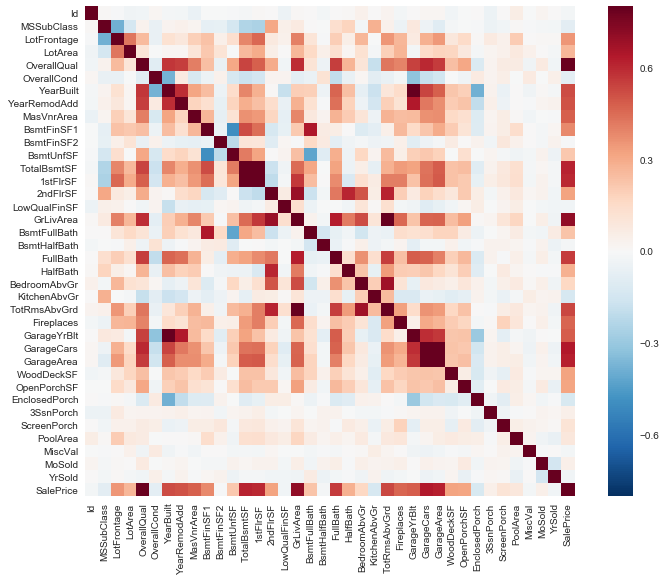

In [2]:
#A little bit of EDA
import seaborn as sns

corrmat2 = train_raw.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat2, vmax=.8, square=True);

corrmat = train_all.corr()
print corrmat.loc[:,corrmat.columns=='SalePrice'].sort_values('SalePrice', ascending=False)

In [3]:
# Set up simplest linear regression model possible:
simple_LR = linear_model.LinearRegression()
simple_LR.fit(X = train_X.GrLivArea.values.reshape(-1, 1), y = train_y.values.reshape(-1, 1))

print("y-intercept: {:,.2f}".format(float(simple_LR.intercept_)))
print("GrLivArea coefficient: {:,.2f}".format(float(simple_LR.coef_)))

simple_LR_pred_labels = simple_LR.predict(dev_X.GrLivArea.values.reshape(-1, 1))
print("Log Root Mean Squared Error: {:,.2f}".format(metrics.mean_squared_error(np.log(dev_y), np.log(simple_LR_pred_labels)) ** 0.5))

# Calculate R-squared values of model.
print("R-squared: {:.2f}".format(metrics.r2_score(dev_y, simple_LR_pred_labels)))

y-intercept: 8,283.58
GrLivArea coefficient: 115.19
Log Root Mean Squared Error: 0.29
R-squared: 0.40


In [6]:
#Maybe Use Decision Tree/Random Forests to Pick Best Features?
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=3, n_estimators=1000)

rf.fit(train_X,train_y)

features = np.where(rf.feature_importances_!=0)[0]
for i in features[:15]:
    print list(train_X)[i]

print len(features)

MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea
BsmtFullBath
80


In [7]:
#pick the features that the random forest thought were the most important
train_X_sel = train_X.loc[:, train_X.columns[[features]]]
dev_X_sel = dev_X.loc[:, dev_X.columns[[features]]]

#fit the regression model using those columns only
rf_LR = linear_model.LinearRegression()
rf_LR.fit(X = train_X_sel, y = train_y)


print("y-intercept: {:,.2f}".format(float(rf_LR.intercept_)))
#print("Other Coefficients:", (rf_LR.coef_))

#make predictions
rf_LR_pred_labels = rf_LR.predict(dev_X_sel)

#print a few actual and predicted values
print dev_y[:10]
print rf_LR_pred_labels[:10]

#check the error
print("Log Root Mean Squared Error: {:,.4f}".format(metrics.mean_squared_error(np.log(dev_y), np.log(rf_LR_pred_labels)) ** 0.5))

# Calculate R-squared values of model.
print("R-squared: {:.2f}".format(metrics.r2_score(dev_y, rf_LR_pred_labels)))

y-intercept: 1,269,767.55
1000     82000
1001     86000
1002    232000
1003    136905
1004    181000
1005    149900
1006    163500
1007     88000
1008    240000
1009    102000
Name: SalePrice, dtype: int64
[  33360.24028061  100067.08160551  217353.15178198  156486.35525649
  184658.37234518  134479.1290176   194792.94139278   72231.19672413
  256525.08515725  108316.89603433]
Log Root Mean Squared Error: 0.1662
R-squared: 0.73


In [8]:
#Write out the csv of predictions
output = dev_X.copy()
output['SalePrice']=simple_LR.predict(output.GrLivArea.values.reshape(-1,1))
output.to_csv('Output.csv',columns=['Id','SalePrice'],index=False)

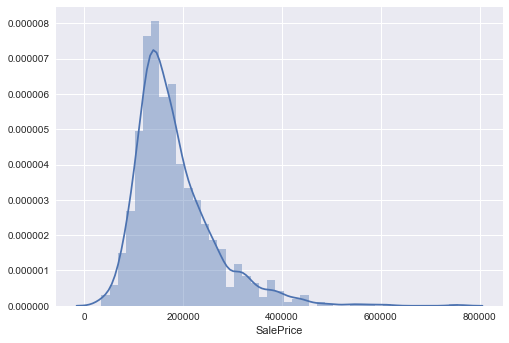

In [9]:
# Transformations prior to boosting

sns.distplot(train_y)

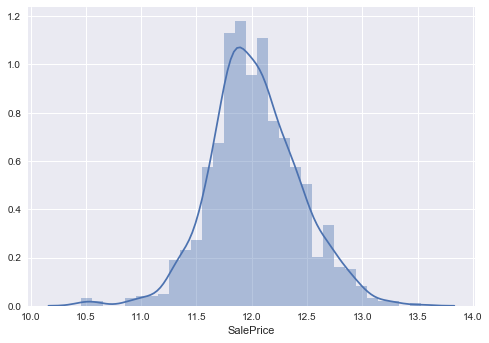

In [10]:
# Large right skew so let's take a log of the SalePrice
train_y_xgb = np.log(train_y)
dev_y_xgb = np.log(dev_y)
sns.distplot(train_y_xgb)

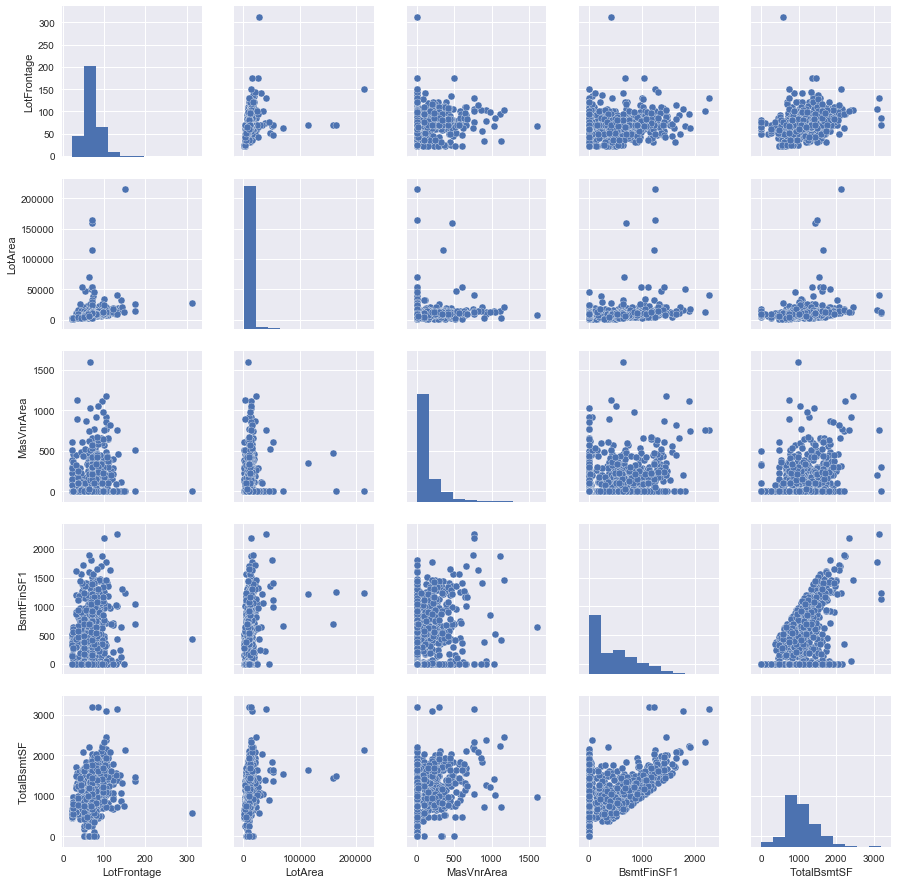

In [11]:
train_X_xgb = train_X.copy()
dev_X_xgb = dev_X.copy()
test_xgb = test_all.copy()
all_xgb = train_all.copy()

all_xgb_X, all_xgb_y = all_xgb.loc[:, all_xgb.columns !='SalePrice'], all_xgb.loc[:, all_xgb.columns == 'SalePrice']
all_xgb_y = np.log(all_xgb_y)
all_xgb_X = all_xgb_X.loc[:, all_xgb_X.columns !='Id']

# Drop variables that had |correlation| < 0.2 to sale price
def try_to_drop(df, col):
    try:
        df.drop(col, axis=1, inplace=True)
    except Exception:
        pass
    return df

for col in corrmat.SalePrice.loc[np.abs(corrmat.SalePrice) < 0.2].index:
    train_X_xgb = try_to_drop(train_X_xgb, col)
    dev_X_xgb = try_to_drop(dev_X_xgb, col)
    test_xgb = try_to_drop(test_xgb, col)
    all_xgb_X = try_to_drop(all_xgb_X, col)

features_to_standardize = [col for col in ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                           'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GrLivAreaSq',
                           'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                           'ScreenPorch', 'PoolArea', 'MiscVal'] if col in train_X_xgb.columns]
# Get a flavor of what a few of these variables look like -- they're basically all square footage
sns.pairplot(train_X_xgb[features_to_standardize[0:min(5, len(features_to_standardize))]])

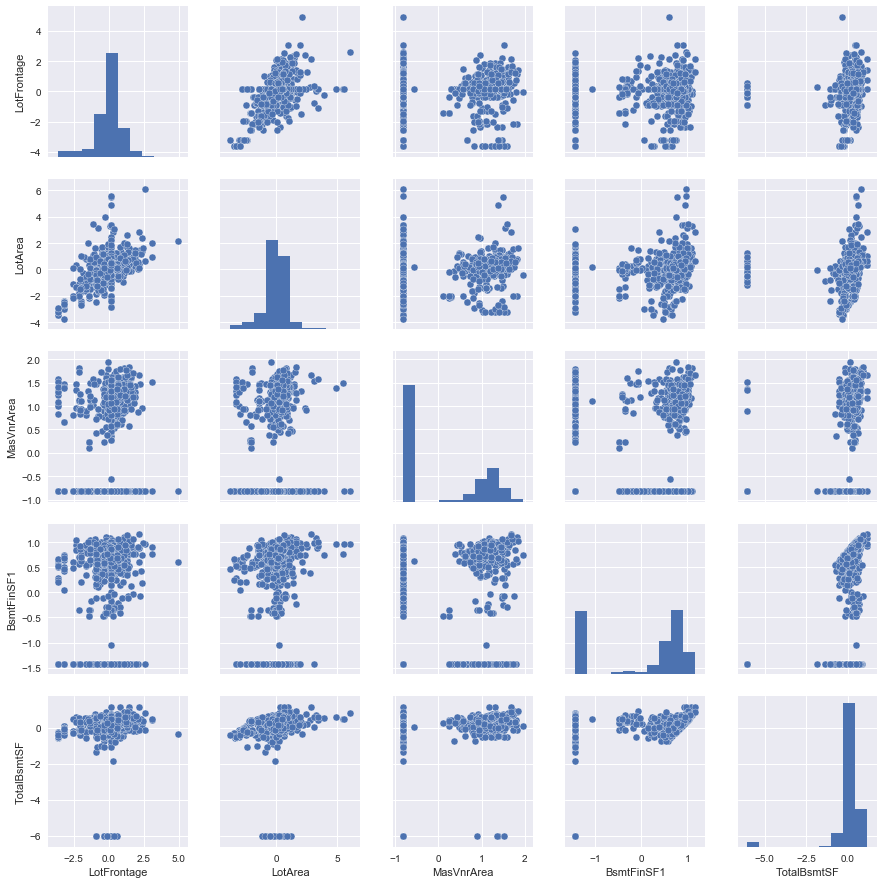

In [12]:
# Take logs, then standardize
def log_and_standardize(df, cols):
    df[cols] = np.log(df[cols] + 1)
    df[cols] = ((df[cols] - df[cols].mean())) / df[cols].std()
    return df
    
train_X_xgb = log_and_standardize(train_X_xgb, features_to_standardize)
dev_X_xgb = log_and_standardize(dev_X_xgb, features_to_standardize)
test_xgb = log_and_standardize(test_xgb, features_to_standardize)
all_xgb_X = log_and_standardize(all_xgb_X, features_to_standardize)

# Plot them again
sns.pairplot(train_X_xgb[features_to_standardize[0:min(5, len(features_to_standardize))]])

In [13]:
# Boosting

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tabulate import tabulate

def tuner(xgb, param_grid):
    grid_search = GridSearchCV(xgb, param_grid, n_jobs=-1)
    grid_search.fit(train_X_xgb, train_y_xgb)
    print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
    header = ['mean_scr', 'std_scr', 'n_est', 'lrn_rate', 'max_depth', 'gamma', 'subsample', 'reg_alpha']
    rows = []
    for x in grid_search.cv_results_['rank_test_score']:
        rows.append(['{:.6f}'.format(grid_search.cv_results_['mean_test_score'][x-1]),
                     '{:.3f}'.format(grid_search.cv_results_['std_test_score'][x-1]),
                     grid_search.cv_results_['param_n_estimators'][x-1], 
                     grid_search.cv_results_['param_learning_rate'][x-1],
                     grid_search.cv_results_['param_max_depth'][x-1],
                     grid_search.cv_results_['param_gamma'][x-1],
                     grid_search.cv_results_['param_subsample'][x-1],
                     grid_search.cv_results_['param_reg_alpha'][x-1]])
    print tabulate(rows, headers=header, tablefmt='orgtbl')
    return grid_search

def make_param_grid(n_estimators=[100], learning_rate=[0.1], max_depth=[5], gamma=[0], subsample=[0.8], reg_alpha=[0]):
    param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                 gamma=gamma, subsample=subsample, reg_alpha=reg_alpha)
    return param_grid

/Users/Michelle/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [356]:
conduct_tuning = False

In [357]:
if conduct_tuning:
    xgb = XGBRegressor()
    n_estimators = [130, 135, 140, 145, 150, 155, 160, 165, 170]
    print('Tuning n_estimators first')
    n_est_result = tuner(xgb, make_param_grid(n_estimators=n_estimators))

In [358]:
if conduct_tuning:
    max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
    print('Tuning max_depth')
    max_depth_result = tuner(xgb, make_param_grid(max_depth=max_depth,
                                                  n_estimators=[n_est_result.best_params_['n_estimators']]))

In [359]:
if conduct_tuning:
    gamma = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    print('Tuning gamma')
    gamma_result = tuner(xgb, make_param_grid(gamma=gamma,
                                              n_estimators=[n_est_result.best_params_['n_estimators']],
                                              max_depth=[max_depth_result.best_params_['max_depth']]))

In [360]:
if conduct_tuning:
    subsample = [0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9]
    print('Tuning subsample')
    subsample_result = tuner(xgb, make_param_grid(subsample=subsample,
                                                  n_estimators=[n_est_result.best_params_['n_estimators']],
                                                  max_depth=[max_depth_result.best_params_['max_depth']],
                                                  gamma=[gamma_result.best_params_['gamma']]))

In [361]:
if conduct_tuning:
    reg_alpha = [0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    print('Tuning reg_alpha')
    reg_alpha_result = tuner(xgb, make_param_grid(reg_alpha=reg_alpha,
                                                  n_estimators=[n_est_result.best_params_['n_estimators']],
                                                  max_depth=[max_depth_result.best_params_['max_depth']],
                                                  gamma=[gamma_result.best_params_['gamma']],
                                                  subsample=[subsample_result.best_params_['subsample']]))

In [362]:
if conduct_tuning:
    learning_rate = [0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14]
    print('Tuning learning_rate')
    learning_rate_result = tuner(xgb, make_param_grid(learning_rate=learning_rate,
                                                      reg_alpha=[reg_alpha_result.best_params_['reg_alpha']],
                                                      n_estimators=[n_est_result.best_params_['n_estimators']],
                                                      max_depth=[max_depth_result.best_params_['max_depth']],
                                                      gamma=[gamma_result.best_params_['gamma']],
                                                      subsample=[subsample_result.best_params_['subsample']]))

In [363]:
if conduct_tuning:
    print('Re-tuning n_estimators and max_depth for fun')
    n_estimators = [100, 140, 200]
    max_depth = [3, 4, 5]
    gamma = [0]
    subsample = [0.8]
    reg_alpha = [1e-5]
    all_result = tuner(xgb, make_param_grid(learning_rate=learning_rate, reg_alpha=reg_alpha, n_estimators=n_estimators,
                                            max_depth=max_depth, gamma=gamma, subsample=subsample))

In [14]:
xgb_final_train_model = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=140, max_depth=4, gamma=0, subsample=0.8)
xgb_final_train_model.fit(train_X_xgb, train_y_xgb)
print("Log Root Mean Squared Error: {:,.4f}"
      .format(mean_squared_error(dev_y_xgb, xgb_final_train_model.predict(dev_X_xgb)) ** 0.5))

Log Root Mean Squared Error: 0.1383


In [365]:
# See if we can make the model more general by improving RMSLE on the dev data with more tuning

conduct_more_tuning = False
to_beat = mean_squared_error(dev_y_xgb, xgb_final_train_model.predict(dev_X_xgb)) ** 0.5

In [366]:
if conduct_more_tuning:
    best_n_estimators = xgb_final_train_model.get_params()['n_estimators']
    best_max_depth = xgb_final_train_model.get_params()['max_depth']
    print('RMSLE to beat is {:.4f}'.format(to_beat))
    print('Tuning n_estimators and max_depth')
    new_best_found = False
    for n_estimators in [100, 140, 200, 300, 400]:
        for max_depth in [3, 4, 5, 6]:
            xgb_dev_model = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=n_estimators,
                                         max_depth=max_depth, gamma=0, subsample=0.8)
            xgb_dev_model.fit(train_X_xgb, train_y_xgb)
            new_rmsle = mean_squared_error(dev_y_xgb, xgb_dev_model.predict(dev_X_xgb)) ** 0.5
            if new_rmsle < to_beat:
                new_best_found = True
                print('New best: RMSLE = {:.4f} with n_estimators = {} and max_depth = {}'
                      .format(new_rmsle, xgb_dev_model.get_params()['n_estimators'], xgb_dev_model.get_params()['max_depth']))
                to_beat = new_rmsle
                best_n_estimators = xgb_dev_model.get_params()['n_estimators']
                best_max_depth = xgb_dev_model.get_params()['max_depth']
    if not new_best_found:
        print('No new best found')

In [367]:
if conduct_more_tuning:
    best_gamma = xgb_final_train_model.get_params()['gamma']
    best_subsample = xgb_final_train_model.get_params()['subsample']
    print('RMSLE to beat is {:.4f}'.format(to_beat))
    print('Tuning gamma and subsample')
    new_best_found = False
    for gamma in [0, 0.1, 0.2]:
        for subsample in [0.7, 0.8, 0.9]:
            xgb_dev_model = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=140,
                                         max_depth=5, gamma=gamma, subsample=subsample)
            xgb_dev_model.fit(train_X_xgb, train_y_xgb)
            new_rmsle = mean_squared_error(dev_y_xgb, xgb_dev_model.predict(dev_X_xgb)) ** 0.5
            if new_rmsle < to_beat:
                new_best_found = True
                print('New best: RMSLE = {:.4f} with gamma = {} and subsample = {}'
                      .format(new_rmsle, xgb_dev_model.get_params()['gamma'], xgb_dev_model.get_params()['subsample']))
                to_beat = new_rmsle
                best_gamma = xgb_dev_model.get_params()['gamma']
                best_subsample = xgb_dev_model.get_params()['subsample']
    if not new_best_found:
        print('No new best found')

RMSLE to beat is 0.1313
Tuning gamma and subsample
No new best found

In [368]:
if conduct_more_tuning:
    best_reg_alpha = xgb_final_train_model.get_params()['reg_alpha']
    best_learning_rate = xgb_final_train_model.get_params()['learning_rate']
    print('RMSLE to beat is {:.4f}'.format(to_beat))
    print('Tuning reg_alpha and learning_rate')
    new_best_found = False
    for reg_alpha in [0, 0.1, 0.2]:
        for learning_rate in [0.7, 0.8, 0.9]:
            xgb_dev_model = XGBRegressor(learning_rate=learning_rate, reg_alpha=reg_alpha, n_estimators=140,
                                         max_depth=5, gamma=0, subsample=0.8)
            xgb_dev_model.fit(train_X_xgb, train_y_xgb)
            new_rmsle = mean_squared_error(dev_y_xgb, xgb_dev_model.predict(dev_X_xgb)) ** 0.5
            if new_rmsle < to_beat:
                new_best_found = True
                print('New best: RMSLE = {:.4f} with reg_alpha = {} and learning_rate = {}'
                      .format(new_rmsle, xgb_dev_model.get_params()['reg_alpha'], xgb_dev_model.get_params()['learning_rate']))
                to_beat = new_rmsle
                best_reg_alpha = xgb_dev_model.get_params()['reg_alpha']
                best_learning_rate = xgb_dev_model.get_params()['learning_rate']
    if not new_best_found:
        print('No new best found')

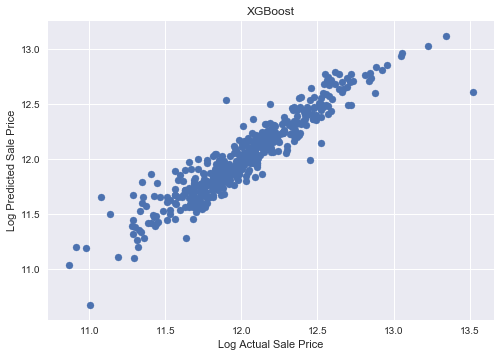

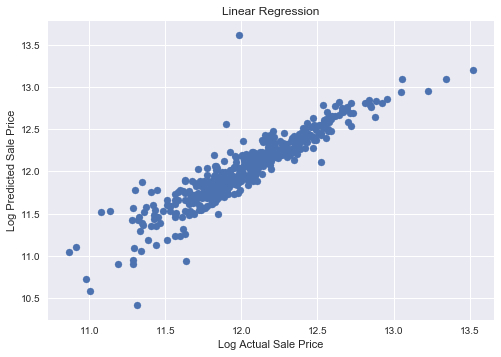

Root Mean Squared Log Error XGBoost: 0.1347
Root Mean Squared Log Error Linear Regression: 0.1662


In [15]:
xgb_optim = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=140, max_depth=5, gamma=0, subsample=0.8)
xgb_optim.fit(train_X_xgb, train_y_xgb)
plt.scatter(np.log(dev_y), xgb_optim.predict(dev_X_xgb))
plt.title("XGBoost")
plt.xlabel("Log Actual Sale Price")
plt.ylabel("Log Predicted Sale Price")
plt.show()
plt.scatter(np.log(dev_y), np.log(rf_LR_pred_labels))
plt.title("Linear Regression")
plt.xlabel("Log Actual Sale Price")
plt.ylabel("Log Predicted Sale Price")
plt.show()
print("Root Mean Squared Log Error XGBoost: {:,.4f}"
      .format(mean_squared_error(np.log(dev_y), xgb_optim.predict(dev_X_xgb)) ** 0.5))
print("Root Mean Squared Log Error Linear Regression: {:,.4f}"
      .format(mean_squared_error(np.log(dev_y), np.log(rf_LR_pred_labels)) ** 0.5))

In [16]:
xgb_optim_all_train = XGBRegressor(learning_rate=0.1, reg_alpha=1e-5, n_estimators=140,
                                         max_depth=5, gamma=0, subsample=0.8)
xgb_optim_all_train.fit(all_xgb_X, all_xgb_y)
xgb_predictions = pd.concat([test.Id, pd.Series(np.exp(xgb_optim_all_train.predict(test_xgb)), name='SalePrice')], axis=1)
xgb_predictions.to_csv('Output_xgb.csv', index=False)

In [17]:
from sklearn.linear_model import Lasso

def tuner_lasso(lasso, param_grid):
    grid_search = GridSearchCV(lasso, param_grid, n_jobs=-1)
    grid_search.fit(train_X_xgb, train_y_xgb)
    print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
    header = ['mean_scr', 'std_scr', 'alpha']
    rows = []
    for x in grid_search.cv_results_['rank_test_score']:
        rows.append(['{:.6f}'.format(grid_search.cv_results_['mean_test_score'][x-1]),
                     '{:.3f}'.format(grid_search.cv_results_['std_test_score'][x-1]),
                     grid_search.cv_results_['param_alpha'][x-1]])
    print tabulate(rows, headers=header, tablefmt='orgtbl')
    return grid_search

lasso = Lasso(max_iter=1e5)
lasso_param_grid = {'alpha': [5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 2e-3, 3e-3, 4e-3]}
lasso_grid_search = tuner_lasso(lasso, lasso_param_grid)

Best: 0.885071 using {'alpha': 0.0007}
|   mean_scr |   std_scr |   alpha |
|------------+-----------+---------|
|   0.884992 |     0.018 |  0.0008 |
|   0.885002 |     0.018 |  0.0006 |
|   0.884929 |     0.018 |  0.0005 |
|   0.885071 |     0.018 |  0.0007 |
|   0.884826 |     0.018 |  0.0009 |
|   0.880707 |     0.016 |  0.002  |
|   0.877771 |     0.013 |  0.003  |
|   0.875304 |     0.012 |  0.004  |


In [18]:
# Use same features as xgboost with a lasso regression

lasso_optim = Lasso(max_iter=1e5, alpha=0.0007)
lasso_optim.fit(train_X_xgb, train_y_xgb)
print("Root Mean Squared Log Error Lasso Regression: {:,.4f}"
      .format(mean_squared_error(np.log(dev_y), lasso_optim.predict(dev_X_xgb)) ** 0.5))

lasso_optim_all_train = lasso_optim.fit(all_xgb_X, all_xgb_y)
lasso_predictions = pd.concat([test.Id, pd.Series(np.exp(lasso_optim_all_train.predict(test_xgb)), name='SalePrice')], axis=1)
lasso_predictions.to_csv('Output_lasso.csv', index=False)

Root Mean Squared Log Error Lasso Regression: 0.1512


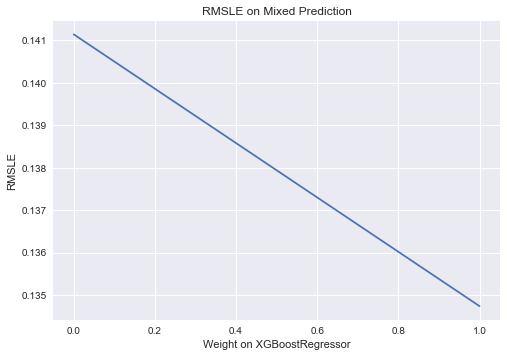

In [19]:
# Combine the two predictions to determine the best mixing weight

xgb_weight = [x/20 for x in range(21)]
mixed_rmsle = []
pred_xgb = xgb_optim.predict(dev_X_xgb)
pred_lasso = lasso_optim.predict(dev_X_xgb)
for x in xgb_weight:
    wtd_pred = x * pred_xgb + (1 - x) * pred_lasso
    rmsle = mean_squared_error(np.log(dev_y), wtd_pred) ** 0.5
    mixed_rmsle.append(rmsle)

plt.plot(xgb_weight, mixed_rmsle)
plt.title('RMSLE on Mixed Prediction')
plt.xlabel('Weight on XGBoostRegressor')
plt.ylabel('RMSLE')
plt.show()

The RMSLE is linear in weight so there's not much to be gained from this information. The lasso regression appears to do worse for predicting the dev data, but submitting the fully trained xgboost regression and lasso regression results to kaggle yields 0.14169 and 0.13902 respectively -- in this case, the lasso estimator is actually better for the test data.

So, naively, we'll try two 50/50 splits: average the model output (a log price) and average the respective price.

In [20]:
avg_log_price_predictions = 0.5 * xgb_optim_all_train.predict(test_xgb) + 0.5 * lasso_optim_all_train.predict(test_xgb)
avg_price_predictions = (0.5 * np.exp(xgb_optim_all_train.predict(test_xgb)) + 
                         0.5 * np.exp(lasso_optim_all_train.predict(test_xgb)))
alp_out = pd.concat([test.Id, pd.Series(np.exp(avg_log_price_predictions), name='SalePrice')], axis=1)
ap_out = pd.concat([test.Id, pd.Series(avg_price_predictions, name='SalePrice')], axis=1)
alp_out.to_csv('Output_avg_log_price.csv', index=False)
ap_out.to_csv('Output_avg_price.csv', index=False)

Averaging the prices yields a kaggle score of 0.13478, and averaging the log prices yields a kaggle score of 0.13506. Our best model so far is therefore the equally weighted price output of the xgboost regression and lasso regression.

Cumulative fraction of total variance explained by first k principal components

k =   1: 0.991
k =   2: 0.998
k =   3: 0.999
k =   4: 1.000
k =   5: 1.000


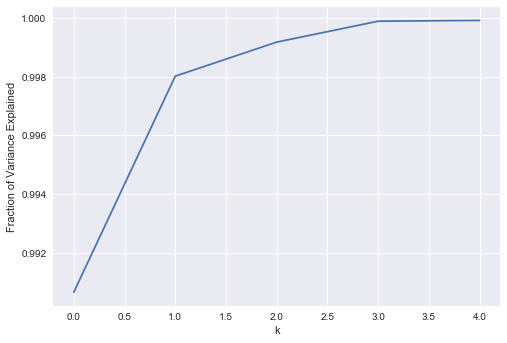

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(train_X_xgb)
explained_array = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative fraction of total variance explained by first k principal components\n")
for x in range(explained_array.shape[0]):
    print("k = {:3d}: {:.3f}".format(x+1, explained_array[x]))
plt.plot(explained_array); plt.xlabel('k'); plt.ylabel('Fraction of Variance Explained')
plt.show()

In [31]:
pca_13 = PCA(n_components=13)
pca_13.fit(train_X_xgb)
pca_lr = linear_model.LinearRegression()
pca_lr.fit(pca_13.transform(train_X_xgb), train_y_xgb)

print("Root Mean Squared Log Error PCA/Linear Regression: {:,.4f}"
      .format(mean_squared_error(np.log(dev_y), pca_lr.predict(pca_13.transform(dev_X_xgb))) ** 0.5))

Root Mean Squared Log Error PCA/Linear Regression: 0.1570


Weights for [PCA, RF, XGB, Lasso]
Best Weights: [0.0, 0.0, 0.6, 0.4]
Root Mean Squared Log Error Ensemble: 0.129269


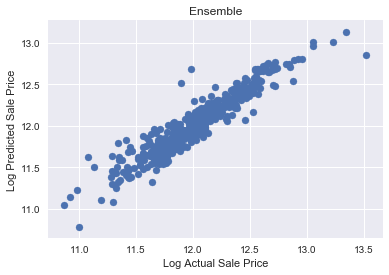

In [89]:
def ensemble(predictions, weights):
    if len(predictions)!=len(weights):
        print "Number of estimators does not match number of weights"
    elif np.sum(weights)!=1:
        print "Weights must add up to 1"
    else:
        final_pred=np.average(predictions, axis=0, weights=weights)
        return final_pred

pca_pred = pca_lr.predict(pca_13.transform(dev_X_xgb))
rf_LR_pred = rf_LR.predict(dev_X_sel)
xgb_optim_pred = xgb_optim.predict(dev_X_xgb)
lasso_pred = lasso_optim.predict(dev_X_xgb)

predictions=[pca_pred, rf_LR_pred, xgb_optim_pred, lasso_pred]
a, b, c, d = [x/20. for x in range(21)],[x/20. for x in range(21)],[x/20. for x in range(21)],[x/20. for x in range(21)]
best_wts = [0,0,0,1]
best_rmse = mean_squared_error(np.log(dev_y), ensemble(predictions, best_wts)) ** 0.5
for i in a:
    for j in b:
        for k in c: 
            for l in d:
                if i+j+k+l==1:
                    wts = [i,j,k,l]
                    rmse = mean_squared_error(np.log(dev_y), ensemble(predictions, wts)) ** 0.5
                    if rmse < best_rmse:
                        best_rmse=rmse
                        best_wts = wts
                        #print wts, "Root Mean Squared Log Error Ensemble: {:,.6f}".format(rmse)
print "Weights for [PCA, RF, XGB, Lasso]"                        
print "Best Weights:", best_wts
print "Root Mean Squared Log Error Ensemble: {:,.6f}".format(best_rmse)


plt.scatter(np.log(dev_y), ensemble(predictions, best_wts))
plt.title("Ensemble")
plt.xlabel("Log Actual Sale Price")
plt.ylabel("Log Predicted Sale Price")
plt.show()

In [ ]:
#Retrain ensemble on all training data, if not done already

#PCA on all training data
pca_13_all = PCA(n_components=13)
pca_13_all.fit(all_xgb_X)
pca_lr_all = linear_model.LinearRegression()
pca_lr_all.fit(pca_13.transform(all_xgb_X), all_xgb_y)

#Random Forest on all training data
rf_all = RandomForestRegressor(max_depth=6, n_estimators=100)
rf_all.fit(all_xgb_X,all_xgb_y)
features_all = np.where(rf_all.feature_importances_!=0)[0]

#pick the features that the random forest thought were the most important
all_X_sel = all_xgb_X.loc[:, all_xgb_X.columns[[features_all]]]
test_X_sel = test_xgb.loc[:,test_xgb.columns[[features_all]]]

#fit the regression model using those columns only
rf_LR_all = linear_model.LinearRegression()
rf_LR_all.fit(X = all_X_sel, y = all_xgb_y)


pca_pred_t = pca_lr_all.predict(pca_13.transform(test_xgb)).ravel()
rf_LR_pred_t = rf_LR_all.predict(test_X_sel).ravel()
xgb_optim_pred_t = xgb_optim_all_train.predict(test_xgb).ravel()
lasso_pred_t = lasso_optim_all_train.predict(test_xgb).ravel()

predictions_test=[np.exp(pca_pred_t), np.exp(rf_LR_pred_t), np.exp(xgb_optim_pred_t), np.exp(lasso_pred_t).ravel()]

avg_price_predictions = ensemble(predictions_test, best_wts)
ap_out = pd.concat([test.Id, pd.Series(avg_price_predictions, name='SalePrice')], axis=1)
ap_out.to_csv('Output_avg_price_ensemble.csv', index=False)